In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#sklearn linear, preprocessing and random forest stuff
from sklearn import preprocessing, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform, randint
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tools.eval_measures import rmse

#statsmodel api
import statsmodels.api as sm

## Load Apples

In [26]:
apples = pd.read_csv('https://raw.githubusercontent.com/mckenzie-maidl/data5100-climate-agriculture/main/Cleaned%20Data/WA_apples_1889_2021.csv')

In [27]:
apples.head()

,Unnamed: 0,year,geo_level,state,yield_acre_lbs,bearing_acre,total_production_lbs,utilized_production_lbs,avg_price_pound_dollars,value_utilized_production_dollars
0,1,2021,STATE,WASHINGTON,39300.0,172000.0,6760000000,6489600000,0.337,2.185373e+09
1,2,2020,STATE,WASHINGTON,39500.0,175000.0,6915000000,6569300000,0.319,2.095265e+09
2,3,2019,STATE,WASHINGTON,44200.0,172000.0,7600000000,7220000000,0.271,1.958900e+09
3,4,2018,STATE,WASHINGTON,39400.0,170000.0,6700000000,6365000000,0.336,2.140650e+09
4,5,2017,STATE,WASHINGTON,45500.0,165000.0,7500000000,7200000000,0.338,2.430353e+09


In [28]:
apples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         133 non-null    int64  
 1   year                               133 non-null    int64  
 2   geo_level                          133 non-null    object 
 3   state                              133 non-null    object 
 4   yield_acre_lbs                     103 non-null    float64
 5   bearing_acre                       103 non-null    float64
 6   total_production_lbs               133 non-null    int64  
 7   utilized_production_lbs            133 non-null    int64  
 8   avg_price_pound_dollars            113 non-null    float64
 9   value_utilized_production_dollars  113 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 10.5+ KB


## Reshape and concatenate

In [29]:
apples2 = apples.dropna().sort_values(by='year').set_index('year')
apples2.head()

,Unnamed: 0,geo_level,state,yield_acre_lbs,bearing_acre,total_production_lbs,utilized_production_lbs,avg_price_pound_dollars,value_utilized_production_dollars
year,,,,,,,,,
1919,103,STATE,WASHINGTON,8810.0,132000.0,1163570000,1163570000,0.0424,49325000.0
1920,102,STATE,WASHINGTON,6530.0,129000.0,841800000,841800000,0.0372,31293000.0
1921,101,STATE,WASHINGTON,11500.0,125500.0,1448999000,1448999000,0.0320,46305000.0
1922,100,STATE,WASHINGTON,10400.0,121500.0,1262654000,1262654000,0.0228,28821000.0
1923,99,STATE,WASHINGTON,12900.0,117500.0,1517999000,1517999000,0.0226,34320000.0


## Create functions to run and evaluate linear regression models

In [30]:
def explore_relationship(df, x_var, y_var):
  X = df[[x_var]]
  y = df[[y_var]]
  plt.scatter(X, y)

In [31]:
#define a function to quickly generate a multiple regression model with a 80/20 split 
def run_regression_ols(df, x, y):
  #get train and test data
  X = df[x]
  y = df[y]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)
  
  #visualize and evaluate
  lin_model_sm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
  print(lin_model_sm.summary())

  return lin_model_sm

In [32]:
#creates a
def run_regression_scikit(df, x, y):
  X = df[x]
  y = df[y]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

  #fit model
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)

  #make predictions
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
  print('Mean of Test Data: %.2f'%np.mean(y_test))

Linear Regression with apple yields

In [33]:
prism = pd.read_csv('https://raw.githubusercontent.com/mckenzie-maidl/data5100-climate-agriculture/main/Cleaned%20Data/prism.csv')

In [34]:
prism.drop(columns='Unnamed: 0', inplace=True)

In [35]:
prism.apply(lambda x: x.isna().sum())

ppt (inches)          0
tmin (degrees F)      0
tmean (degrees F)     0
tmax (degrees F)      0
tdmean (degrees F)    0
vpdmin (hPa)          0
vpdmax (hPa)          0
County                0
year                  0
month                 0
dtype: int64

In [36]:
#rename columns
cols = list(prism.columns)
new = ['ppt', 'tmin', 'tmean', 'tmax', 'tdewmean', 'vpdmin', 'vpdmax', 'county', 'year', 'month']
new_cols = dict(zip(cols,new))
prism.rename(columns=new_cols, inplace=True)

In [37]:
#add in temperature and vpd difference columns
prism['vpddiff'] = prism['vpdmax'] - prism['vpdmin']
prism['tdiff'] = prism['tmax'] - prism['tmin']
prism['vpdmean'] = (prism['vpdmax'] + prism['vpdmin']) / 2

In [38]:
prism2 = prism[prism['year'] >= 1919]

In [39]:
prism2.apply(lambda x: x.isna().sum())

ppt         0
tmin        0
tmean       0
tmax        0
tdewmean    0
vpdmin      0
vpdmax      0
county      0
year        0
month       0
vpddiff     0
tdiff       0
vpdmean     0
dtype: int64

In [40]:
prism2 = prism2.groupby('year').mean()
#take sum of snowfall and precipitation
prism2['ppt'] = prism.groupby('year')['ppt'].sum()
#drop month
prism2.drop(columns='month', inplace=True)

In [41]:
prism2

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean
year,,,,,,,,,,
1919,145.10,34.895833,47.264167,59.641667,30.987500,1.834417,15.238083,13.403667,24.745833,8.536250
1920,148.97,36.669167,48.184167,59.692500,32.499167,1.874833,14.388417,12.513583,23.023333,8.131625
1921,160.58,36.500000,48.312500,60.115000,32.625000,1.826417,14.681333,12.854917,23.615000,8.253875
1922,111.55,34.785833,46.705833,58.618333,30.709167,2.108333,15.553833,13.445500,23.832500,8.831083
1923,158.99,37.255833,49.051667,60.854167,33.350000,1.897417,14.962333,13.064917,23.598333,8.429875
...,...,...,...,...,...,...,...,...,...,...
2017,175.55,37.214167,47.962500,58.707500,32.510000,1.788917,14.796583,13.007667,21.493333,8.292750
2018,135.34,38.705833,49.804167,60.909167,33.755833,1.734167,15.032417,13.298250,22.203333,8.383292
2019,126.79,37.000000,47.501667,58.002500,33.609167,1.395917,13.315250,11.919333,21.002500,7.355583


In [42]:
#join with apples
papp = prism2.join(apples2)

In [43]:
papp

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean,Unnamed: 0,geo_level,state,yield_acre_lbs,bearing_acre,total_production_lbs,utilized_production_lbs,avg_price_pound_dollars,value_utilized_production_dollars
year,,,,,,,,,,,,,,,,,,,
1919,145.10,34.895833,47.264167,59.641667,30.987500,1.834417,15.238083,13.403667,24.745833,8.536250,103,STATE,WASHINGTON,8810.0,132000.0,1163570000,1163570000,0.0424,4.932500e+07
1920,148.97,36.669167,48.184167,59.692500,32.499167,1.874833,14.388417,12.513583,23.023333,8.131625,102,STATE,WASHINGTON,6530.0,129000.0,841800000,841800000,0.0372,3.129300e+07
1921,160.58,36.500000,48.312500,60.115000,32.625000,1.826417,14.681333,12.854917,23.615000,8.253875,101,STATE,WASHINGTON,11500.0,125500.0,1448999000,1448999000,0.0320,4.630500e+07
1922,111.55,34.785833,46.705833,58.618333,30.709167,2.108333,15.553833,13.445500,23.832500,8.831083,100,STATE,WASHINGTON,10400.0,121500.0,1262654000,1262654000,0.0228,2.882100e+07
1923,158.99,37.255833,49.051667,60.854167,33.350000,1.897417,14.962333,13.064917,23.598333,8.429875,99,STATE,WASHINGTON,12900.0,117500.0,1517999000,1517999000,0.0226,3.432000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,175.55,37.214167,47.962500,58.707500,32.510000,1.788917,14.796583,13.007667,21.493333,8.292750,5,STATE,WASHINGTON,45500.0,165000.0,7500000000,7200000000,0.3380,2.430353e+09
2018,135.34,38.705833,49.804167,60.909167,33.755833,1.734167,15.032417,13.298250,22.203333,8.383292,4,STATE,WASHINGTON,39400.0,170000.0,6700000000,6365000000,0.3360,2.140650e+09
2019,126.79,37.000000,47.501667,58.002500,33.609167,1.395917,13.315250,11.919333,21.002500,7.355583,3,STATE,WASHINGTON,44200.0,172000.0,7600000000,7220000000,0.2710,1.958900e+09


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


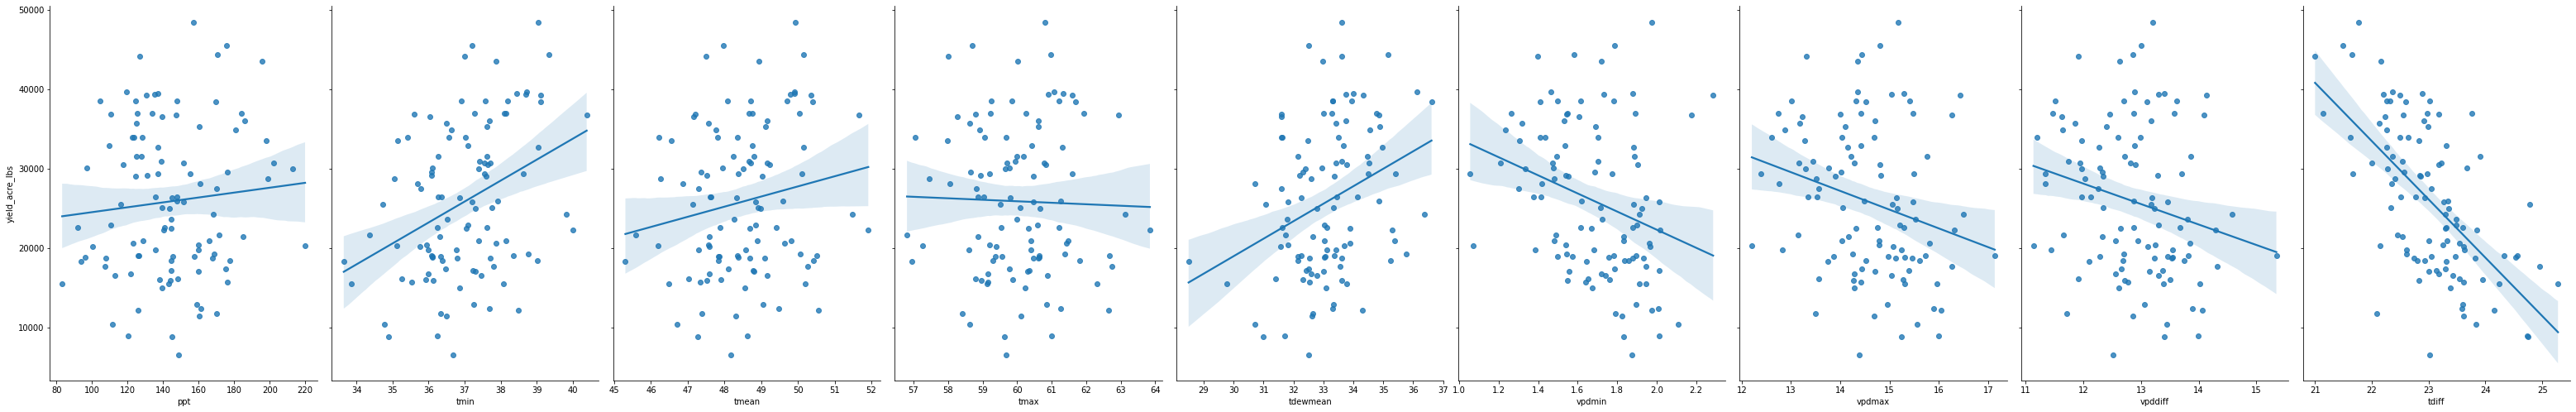

In [44]:
sns.pairplot(papp, x_vars=list(papp.columns[:9]), y_vars='yield_acre_lbs', size=7, aspect=0.7, kind='reg')

In [45]:
run_regression_ols(papp, list(papp[['ppt', 'tdewmean', 'vpdmin','vpdmax', 'vpddiff', 'tdiff', 'vpdmean']]), 'yield_acre_lbs')


                            OLS Regression Results                            
Dep. Variable:         yield_acre_lbs   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     13.39
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           2.33e-09
Time:                        23:41:09   Log-Likelihood:                -841.98
No. Observations:                  82   AIC:                             1696.
Df Residuals:                      76   BIC:                             1710.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.102e+05   4.09e+04      5.140      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
run_regression_ols(papp, list(papp[['ppt', 'vpdmin', 'vpddiff', 'tdiff', 'vpdmean']]), 'yield_acre_lbs')

                            OLS Regression Results                            
Dep. Variable:         yield_acre_lbs   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     16.87
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           5.67e-10
Time:                        23:41:09   Log-Likelihood:                -842.07
No. Observations:                  82   AIC:                             1694.
Df Residuals:                      77   BIC:                             1706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.223e+05   2.82e+04      7.879      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
run_regression_scikit(papp, list(papp[['ppt', 'vpdmin', 'vpddiff', 'tdiff', 'vpdmean']]), 'yield_acre_lbs')

 Accuracy of the model is 64.27
Root Mean squared error: 4980.69
Mean of Test Data: 29000.00
